In [1]:
# import libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import time

# random seeds
tf.random.set_seed(100)
np.random.seed(100)

In [2]:
def true_function(X):
    return 2 * tf.math.sin(X[:, 0]) + 3 * tf.math.cos(X[:, 1]) + 0.5 * X[:, 2]**2 + 0.1 * X[:, 0] * X[:, 1] * X[:, 2]

def generate_dataset(n=1000):
    X = tf.random.uniform((n, 3), minval=-2, maxval=2)
    y_clean = true_function(X)
    y_noisy = y_clean + tf.random.normal((n,), stddev=0.5)
    return tf.cast(X, tf.float32), tf.reshape(y_noisy, (-1, 1))

X_train, y_train = generate_dataset(1000)
X_test, y_test = generate_dataset(200)

print(f"Train shape: {X_train.shape}, {y_train.shape}")
print(f"Test shape: {X_test.shape}, {y_test.shape}")

Train shape: (1000, 3), (1000, 1)
Test shape: (200, 3), (200, 1)


In [3]:
def build_model(input_dim=3, hidden1=10, hidden2=5, output_dim=1):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(input_dim,)),
        tf.keras.layers.Dense(hidden1, activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.Dense(hidden2, activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.Dense(output_dim, kernel_initializer='he_normal')
    ])
    return model

model = build_model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101 (404.00 B)

 Trainable params: 101 (404.00 B)

 Non-trainable params: 0 (0.00 B)

In [4]:
def mse_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)

@tf.function
def train_step(model, X, y):
    with tf.GradientTape() as tape:
        predictions = model(X, training=True)
        loss = mse_loss(y, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [5]:
epochs = 3000
batch_size = 64
log_interval = 100
loss_history = []

train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(batch_size)

start = time.time()
for epoch in range(epochs):
    total_loss = 0
    for batch_x, batch_y in train_ds:
        total_loss += train_step(model, batch_x, batch_y)
    avg_loss = total_loss / len(train_ds)

    if epoch % log_interval == 0:
        print(f"Epoch {epoch}, Loss: {avg_loss.numpy():.4f}")
    if epoch % 10 == 0:
        loss_history.append(avg_loss.numpy())
end = time.time()

print(f"Training completed in {end - start:.2f} seconds")

Epoch 0, Loss: 4.2176
Epoch 100, Loss: 0.3021
Epoch 200, Loss: 0.2546
Epoch 300, Loss: 0.2501
Epoch 400, Loss: 0.2468
Epoch 500, Loss: 0.2375
Epoch 600, Loss: 0.2414
Epoch 700, Loss: 0.2580
Epoch 800, Loss: 0.2382
Epoch 900, Loss: 0.2407
Epoch 1000, Loss: 0.2473
Epoch 1100, Loss: 0.2445
Epoch 1200, Loss: 0.2421
Epoch 1300, Loss: 0.2348
Epoch 1400, Loss: 0.2428
Epoch 1500, Loss: 0.2439
Epoch 1600, Loss: 0.2387
Epoch 1700, Loss: 0.2399
Epoch 1800, Loss: 0.2429
Epoch 1900, Loss: 0.2366
Epoch 2000, Loss: 0.2379
Epoch 2100, Loss: 0.2353
Epoch 2200, Loss: 0.2381
Epoch 2300, Loss: 0.2374
Epoch 2400, Loss: 0.2418
Epoch 2500, Loss: 0.2376
Epoch 2600, Loss: 0.2384
Epoch 2700, Loss: 0.2362
Epoch 2800, Loss: 0.2366
Epoch 2900, Loss: 0.2440
Training completed in 107.45 seconds


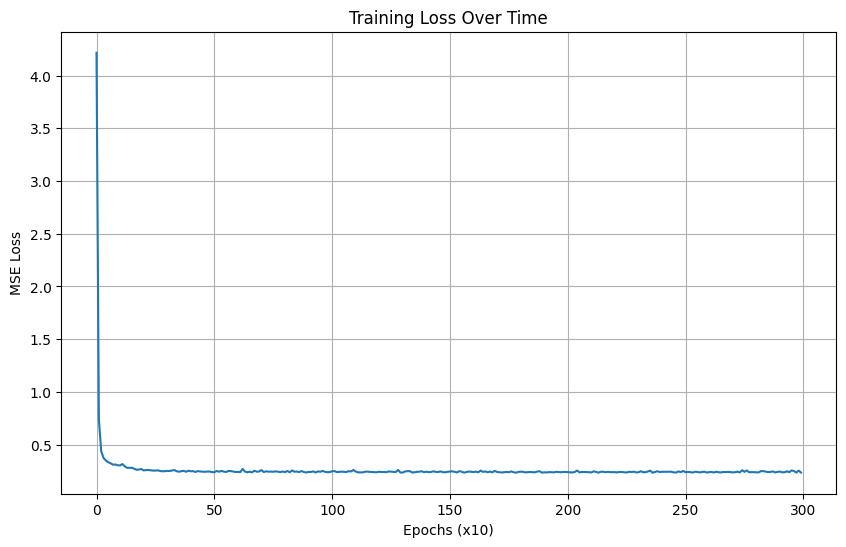

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(loss_history)
plt.xlabel('Epochs (x10)')
plt.ylabel('MSE Loss')
plt.title('Training Loss Over Time')
plt.grid(True)
plt.show()

Test MSE Loss: 0.291772


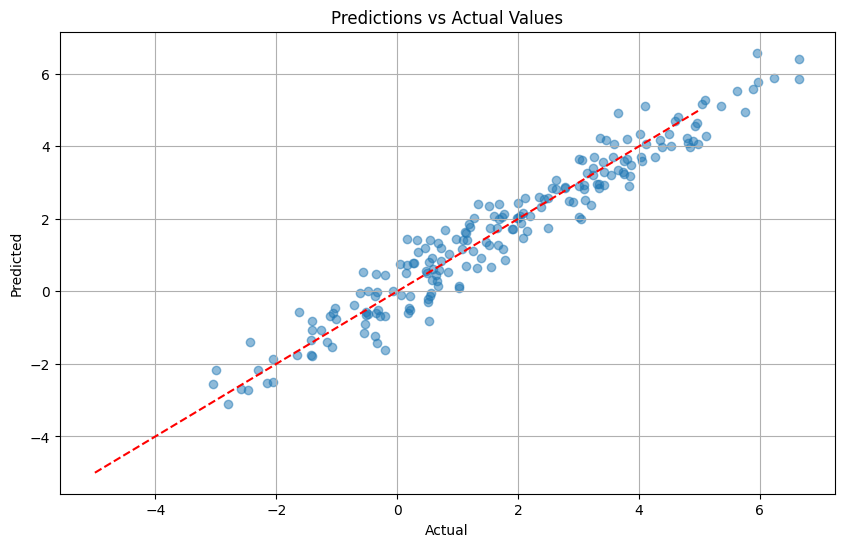

In [7]:
y_pred_test = model(X_test)
test_mse = mse_loss(y_test, y_pred_test).numpy()
print(f"Test MSE Loss: {test_mse:.6f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test.numpy(), y_pred_test.numpy(), alpha=0.5)
plt.plot([-5, 5], [-5, 5], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predictions vs Actual Values')
plt.grid(True)
plt.show()

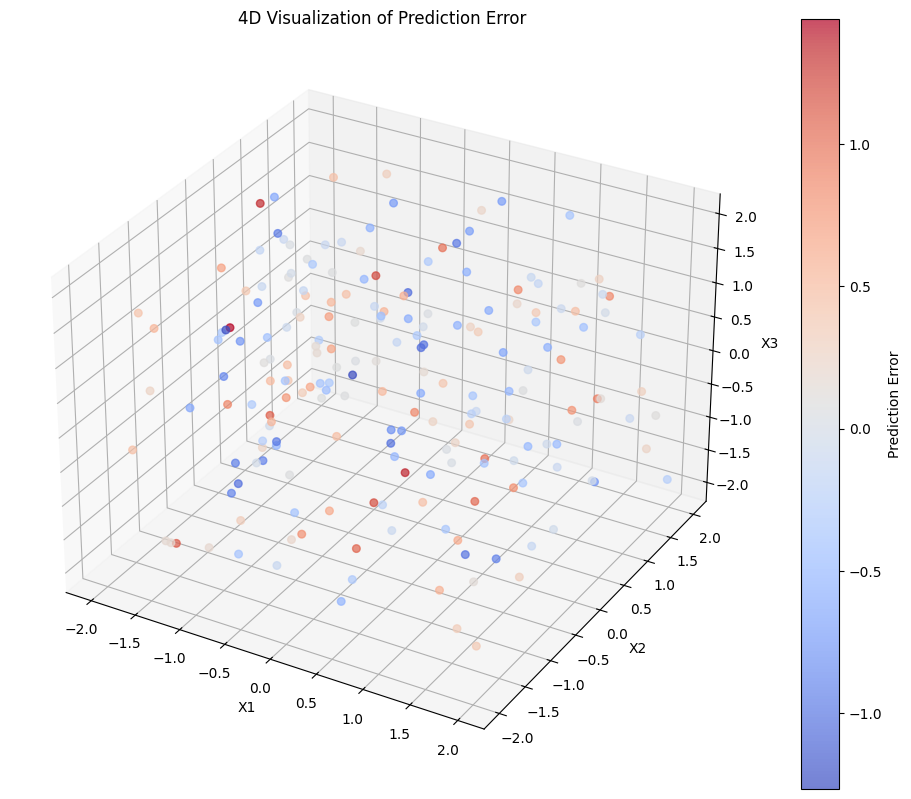

In [8]:
def visualize_4d(X, y_true, y_pred, title):
    X_np = X.numpy()
    error = (y_true - y_pred).numpy().flatten()

    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X_np[:, 0], X_np[:, 1], X_np[:, 2], c=error, cmap=cm.coolwarm, alpha=0.7, s=30)
    cbar = plt.colorbar(scatter)
    cbar.set_label('Prediction Error')

    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('X3')
    ax.set_title(title)
    plt.show()

X_vis, y_vis = generate_dataset(200)
y_vis_pred = model(X_vis)
visualize_4d(X_vis, y_vis, y_vis_pred, '4D Visualization of Prediction Error')

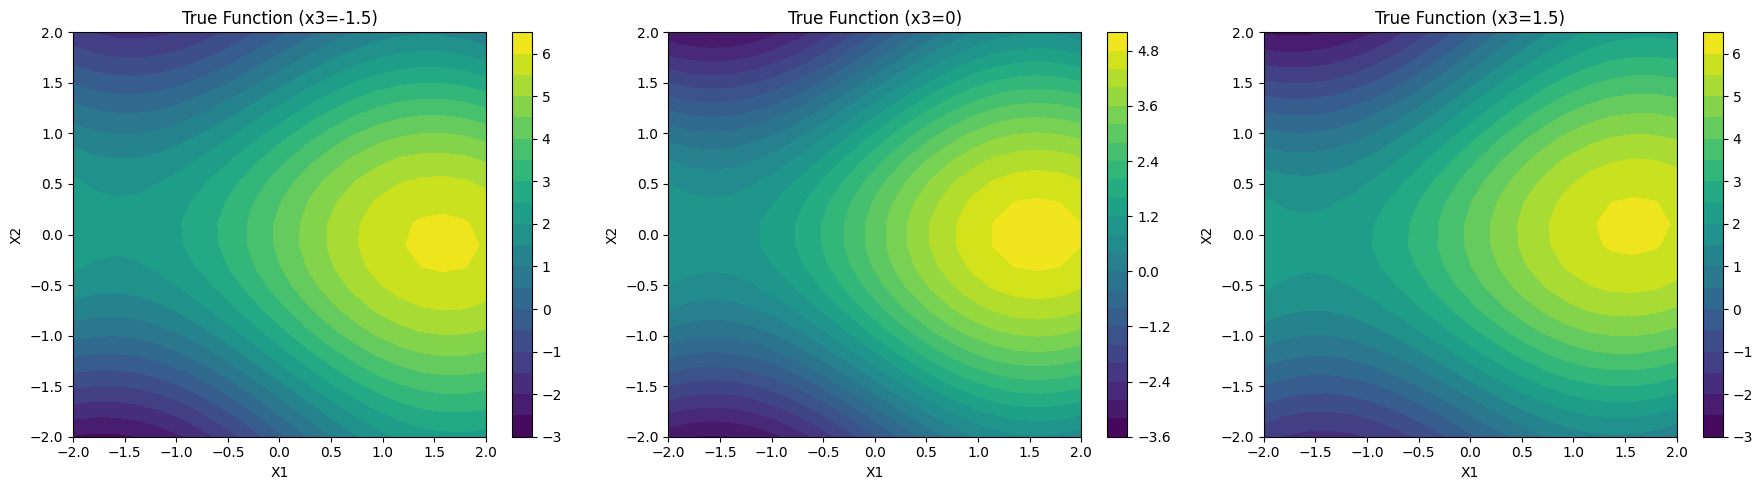

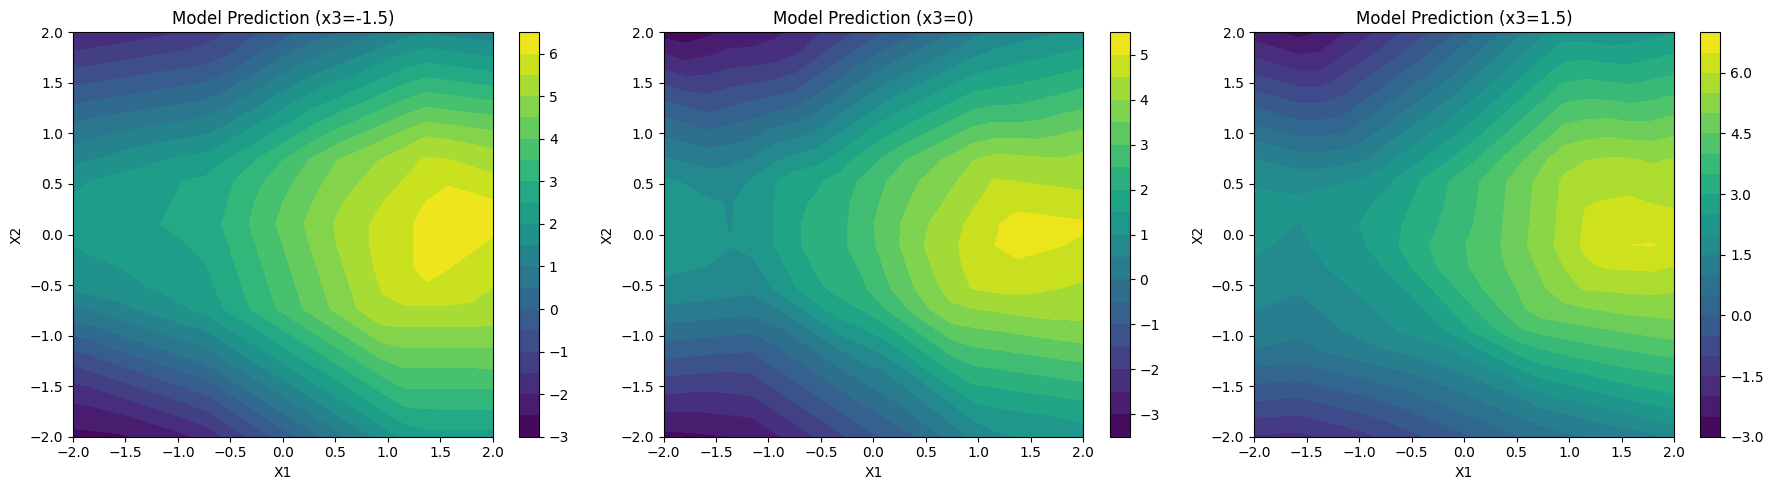

In [9]:
def plot_2d_slices(x_range=2.0, grid_size=20):
    x1 = np.linspace(-x_range, x_range, grid_size)
    x2 = np.linspace(-x_range, x_range, grid_size)
    x3_vals = [-1.5, 0, 1.5]

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    for i, x3 in enumerate(x3_vals):
        X1, X2 = np.meshgrid(x1, x2)
        X_grid = np.stack([X1.flatten(), X2.flatten(), np.full_like(X1.flatten(), x3)], axis=1)

        X_tensor = tf.convert_to_tensor(X_grid, dtype=tf.float32)
        y_true = true_function(X_tensor).numpy().reshape(grid_size, grid_size)
        y_pred = model(X_tensor).numpy().reshape(grid_size, grid_size)

        im = axs[i].contourf(X1, X2, y_true, levels=20, cmap='viridis')
        axs[i].set_title(f"True Function (x3={x3})")
        axs[i].set_xlabel('X1')
        axs[i].set_ylabel('X2')
        plt.colorbar(im, ax=axs[i])
    plt.tight_layout()
    plt.show()

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    for i, x3 in enumerate(x3_vals):
        X1, X2 = np.meshgrid(x1, x2)
        X_grid = np.stack([X1.flatten(), X2.flatten(), np.full_like(X1.flatten(), x3)], axis=1)

        X_tensor = tf.convert_to_tensor(X_grid, dtype=tf.float32)
        y_pred = model(X_tensor).numpy().reshape(grid_size, grid_size)

        im = axs[i].contourf(X1, X2, y_pred, levels=20, cmap='viridis')
        axs[i].set_title(f"Model Prediction (x3={x3})")
        axs[i].set_xlabel('X1')
        axs[i].set_ylabel('X2')
        plt.colorbar(im, ax=axs[i])
    plt.tight_layout()
    plt.show()

plot_2d_slices()